In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
start = time.time()
df = pd.read_csv('co2_data.csv')
end = time.time()
print("Loading took " + str(round(end - start, 2)) + " seconds")

Loading took 0.01 seconds


In [3]:
df.head(5)

,CO2,Year&Month,Year
0,333.13,1974.38,1974
1,332.09,1974.46,1974
2,331.10,1974.54,1974
3,329.14,1974.63,1974
4,327.36,1974.71,1974


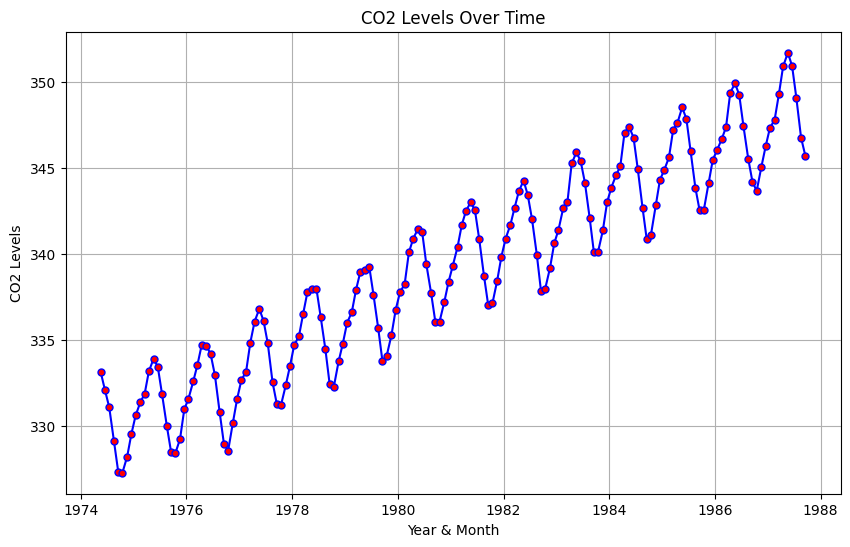

In [6]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df['Year&Month'], df['CO2'], marker='o',markersize=5,markerfacecolor='red', color='blue')
# Add labels and title
plt.xlabel('Year & Month')
plt.ylabel('CO2 Levels')
plt.title('CO2 Levels Over Time')
# Show the plot
plt.grid(True)
plt.show()